In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


print("Libraries imported")

Libraries imported


In [3]:
fraudData = pd.read_csv("creditcard.csv")
print("Data loaded")

Data loaded


I'm going to explore this dataset in order to try to find out how fraud detection might work, and which of these features contributes the most to it. The first thing I'm going to do is use PCA to visualize the data and hopefully answer the second question.

In [5]:
#Make copy of the data frame to mess around with
X = fraudData.copy()
Y = X.pop('Class')

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64


In [24]:
#set up PCA using 3 components in order to visualize the data
#... appears that the first 2 components account for less than 10 % of the variance
pca = PCA(n_components = 2)
results = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[9.99972249e-01 2.77382192e-05]


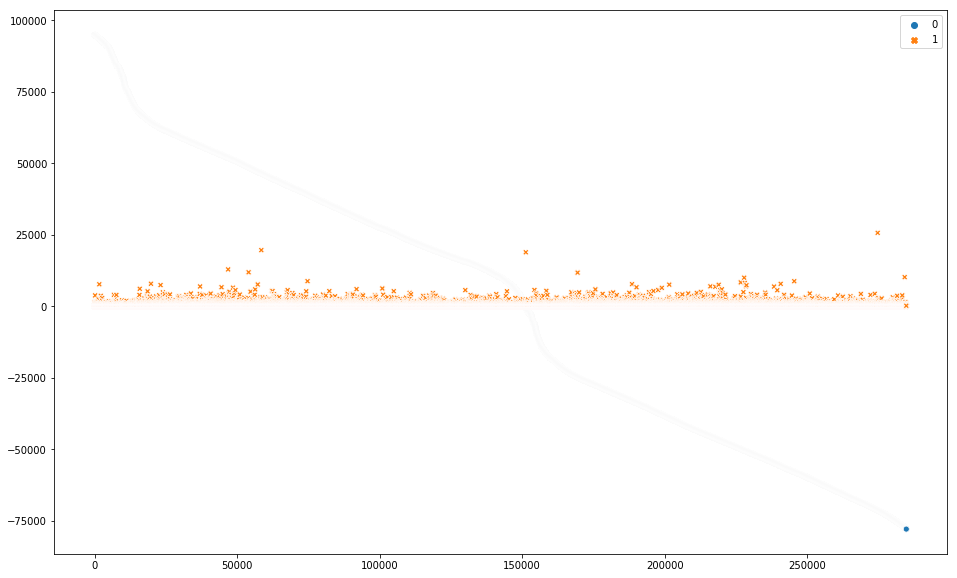

In [25]:
#let's visualize anyway I guess
pca1 = pd.DataFrame(results[:,0])
pca2 = pd.DataFrame(results[:,1])

plt.figure(figsize=(16,10))
sns.scatterplot(
               data = pd.DataFrame(results)
               )

In [3]:
train, test = train_test_split(fraudData, test_size = 0.4, random_state = 420)

train_class = train.pop('Class')
test_class = test.pop('Class')
print(train_class.shape)
print(test_class.shape)
train_data = train
test_data = test
print(train_data.shape)
print(test_data.shape)


(170884,)
(113923,)
(170884, 30)
(113923, 30)


Trying a linear support vector classifier out of the box

In [61]:
classifier = svm.LinearSVC()
classifier.fit(train_data[:-1], train_class[:-1])

KeyboardInterrupt: 

# The classifier.fit method returned "Liblinear failed to converge, increase the number of iterations." 

I read that this means that the data is not well posed for a linearSVC. I will have to read more about this. The regular SVC uses a nonlinear kernel, resulting in much higher complexity. I didn't want to wait so long to get the model up and running. I will explore this model (and other types of classifiers used in fraud detection) and see what the industry uses. 


In [ ]:
classifier = svm.LinearSVC(C = 1000, max_iter = 1000000)
classifier.fit(train_data[:-1], train_class[:-1])

first method of attack: increase max iterations parameter to 1,000,000
-- didn't work
Change penalty C? trying with C = 1000

I am too impatient to see if this converges, I'm going to try a different method. Maybe a decision tree?

Next up: Naive Bayes Classification
This uses bayes theorem to classify (need to read more about the details of the algorithm (finding articles that go sufficiently in depth is a pain; I will probably just break out my bayesian text book))
First iteration: Using GaussianNB directly out of the box

In [4]:
classifier = GaussianNB()
classifier.fit(train_data, train_class)

GaussianNB(priors=None, var_smoothing=1e-09)

In [5]:
print(classifier.predict(train_data[-1:]))
print(train_class[-1:])

[0]
193608    0
Name: Class, dtype: int64


Successfully predicts the class of the last sample in the training data

In [6]:
predictedTest = classifier.predict(test_data)
print(sum(predictedTest))
print(sum(test_class))
print("Accuracy: ({0:.4f})".format(metrics.accuracy_score(test_class, predictedTest)))

856
203
Accuracy: (0.9931)


Getting 99% accuracy but also getting a bunch of false positives. Is there a way to reduce that on a reasonable timescale? Here's a confusion matrix

In [7]:
print(metrics.confusion_matrix(test_class, predictedTest))

[[113001    719]
 [    66    137]]


Since the data is anonymized so much, I am not sure if I can select biggest predictors of fraud in an interpretable way. Maybe PCA is a good move here?